In [ ]:
import os
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Path to your dataset
dataset_path = '/kaggle/input/lhq-1024'

# List all subdirectories (each corresponding to a class)
class_directories = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Initialize empty lists for training and testing files
train_files = []
test_files = []

# Iterate through each class directory
for class_dir in class_directories:
    # List all files in the class directory
    class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.jpg') or file.endswith('.png')]

    # Split the files into training and testing sets
    class_train_files, class_test_files = train_test_split(class_files, test_size=0.2, random_state=42)

    # Append the class-specific training and testing files to the overall lists
    train_files.extend(class_train_files)
    test_files.extend(class_test_files)

# Limit the number of images to 2000
train_files = train_files[:16000]
test_files = test_files[16000:20000]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


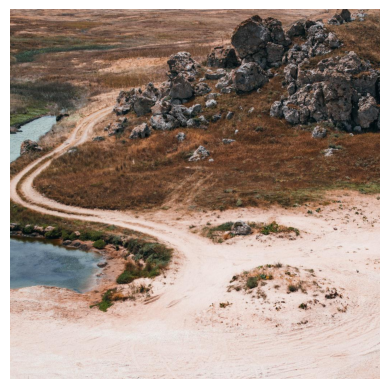

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Assuming train_files[0] contains the path to an image file
image_path = train_files[7]

# Load and display the image
image = imread(image_path)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
def load_and_resize_images(file_paths, target_size=(100, 100)):
    images = []
    for image_path in file_paths:
        with Image.open(image_path) as img:
            # Resize the image
            resized_img = img.resize(target_size)
            img_array = np.array(resized_img)
            images.append(img_array)
    return np.array(images)

# Load and resize training images
X_train = load_and_resize_images(train_files)

# Load and resize testing images
X_test  = load_and_resize_images(test_files)

# Display the shape of the new resized arrays
print(f"Shape of X_train_resized: {X_train.shape}")
print(f"Shape of X_test_resized: {X_test.shape}")

Shape of X_train_resized: (16000, 100, 100, 3)
Shape of X_test_resized: (2000, 100, 100, 3)


In [ ]:
X_train=X_train/255
X_test=X_test/255

In [ ]:
# Add Gaussian noise to the original images
mu = 0.0
sigma = 0.1
noisy_train = X_train + np.random.normal(loc=mu, scale=sigma, size=X_train.shape)
noisy_test = X_test + np.random.normal(loc=mu, scale=sigma, size=X_test.shape)

In [ ]:
noisy_train.shape

(16000, 100, 100, 3)

In [ ]:
gauss_noise=np.random.normal(loc=mu, scale=sigma, size=X_train.shape)

Text(0.5, 1.0, 'Combined')

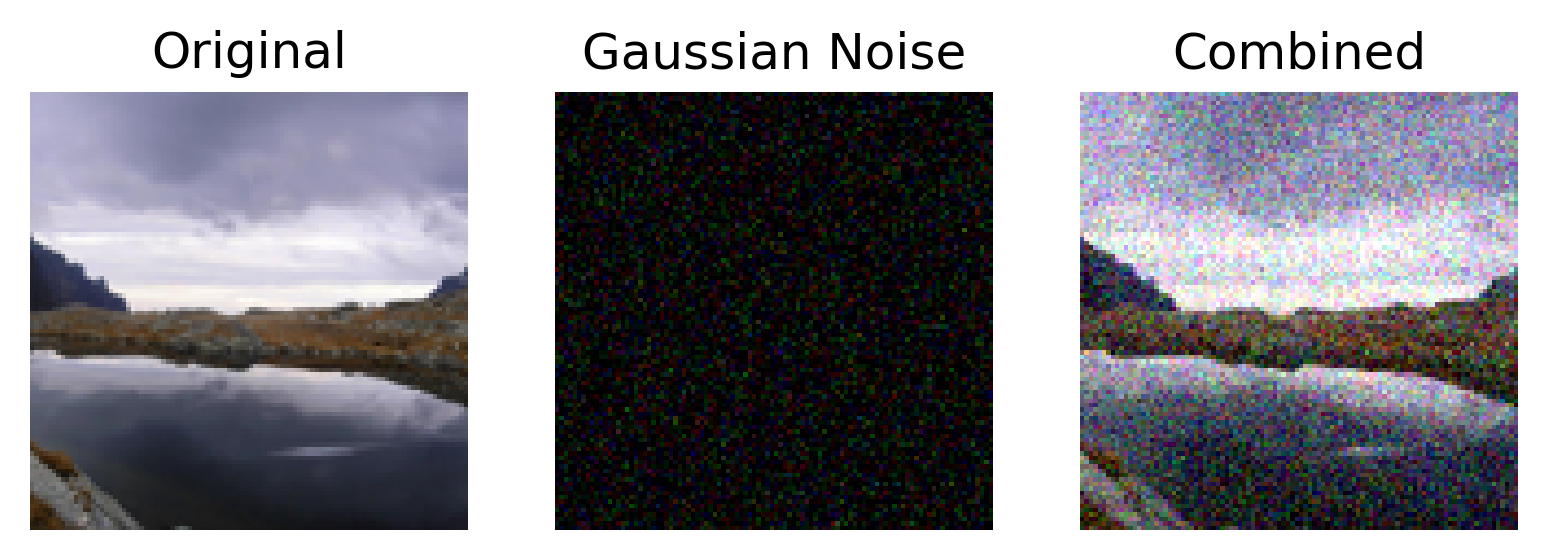

In [ ]:
fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(X_train[1])
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(gauss_noise[1])
plt.axis("off")
plt.title("Gaussian Noise")

fig.add_subplot(1,3,3)
plt.imshow(noisy_train[1])
plt.axis("off")
plt.title("Combined")

In [ ]:
import keras
from keras import layers

In [ ]:
encoding_dim = 1000  # This is the size of our encoded representations

In [ ]:
noisy_train_flatten=noisy_train.reshape(len(noisy_train),-1)
noisy_test_flatten=noisy_test.reshape(len(noisy_test),-1)

In [ ]:
X_train_flatten=X_train.reshape(len(X_train),-1)
X_test_flatten=X_test.reshape(len(X_test),-1)

In [ ]:
input_img = keras.Input(shape=(30000,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(30000, activation='sigmoid')(encoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)

In [ ]:
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')  #autoencoder.compile(optimizer='adam', loss='mse')  #

In [ ]:
autoencoder.fit(noisy_train_flatten, X_train_flatten,
                epochs=10,
#                 batch_size=8,
                shuffle=True,
                validation_data=(noisy_test_flatten, X_test_flatten))

Epoch 1/10
500/500 [==============================] - 14s 18ms/step - loss: 0.0320 - val_loss: 0.0272
Epoch 2/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0238 - val_loss: 0.0242
Epoch 3/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0213 - val_loss: 0.0207
Epoch 4/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0195 - val_loss: 0.0197
Epoch 5/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0183 - val_loss: 0.0189
Epoch 6/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0173 - val_loss: 0.0199
Epoch 7/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0167 - val_loss: 0.0183
Epoch 8/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0161 - val_loss: 0.0166
Epoch 9/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0155 - val_loss: 0.0170
Epoch 10/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0155 - val_l

In [ ]:
encoded_imgs = encoder.predict(noisy_test_flatten)
decoded_imgs = decoder.predict(encoded_imgs)

63/63 [==============================] - 0s 2ms/step


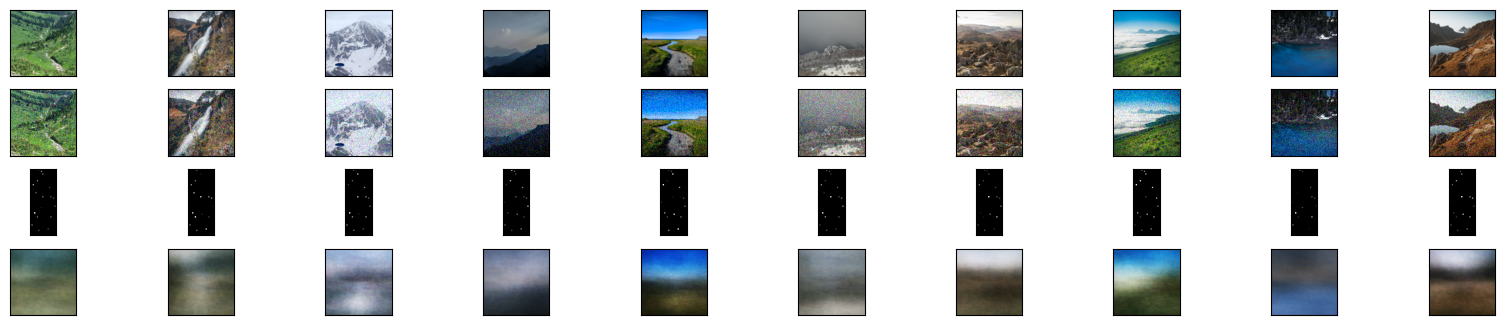

In [ ]:
# Visualize the results
n = 10  # Number of images to display
plt.figure(figsize=(20, 5))

for i in range(n):
    # Original images
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(X_test[i].reshape(100, 100, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



    # Noisy images
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(100,100,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



    # Encoded images
    ax = plt.subplot(5, n, i + 1 + 2 * n)
    plt.imshow(encoded_imgs[i].reshape(50,20))  # Adjust the reshape dimensions based on the actual shape of encoded images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)




    # Decoded images from noisy images
    ax = plt.subplot(5, n, i + 1 + 3 * n)
    plt.imshow(decoded_imgs[i].reshape(100, 100, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.show()


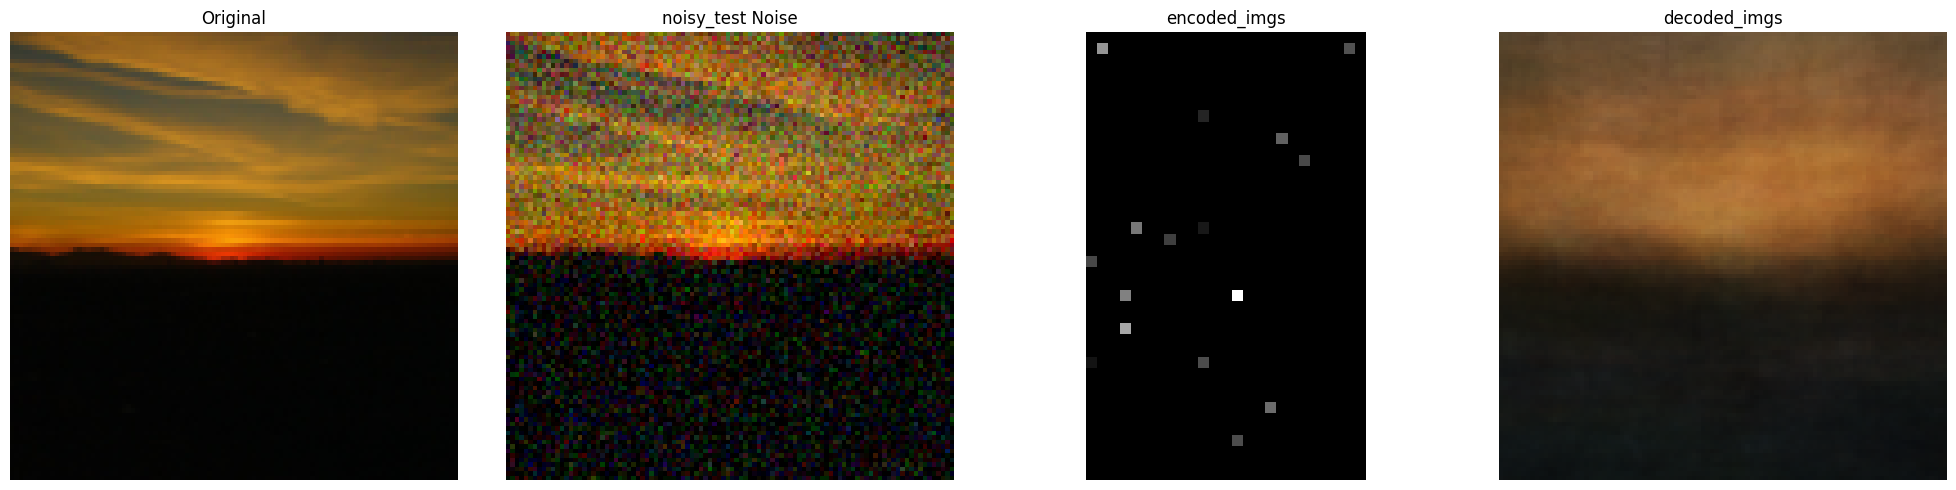

In [ ]:
fig=plt.figure(figsize=(20,5))

fig.add_subplot(1,4,1)
plt.imshow(X_test[51].reshape(100, 100, 3))
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,4,2)
plt.imshow(noisy_test[51].reshape(100, 100, 3))
plt.axis("off")
plt.title("noisy_test Noise")

fig.add_subplot(1,4,3)
plt.imshow(encoded_imgs[51].reshape(40, 25))
plt.axis("off")
plt.title("encoded_imgs")

fig.add_subplot(1,4,4)
plt.imshow(decoded_imgs[51].reshape(100, 100, 3))
plt.axis("off")
plt.title("decoded_imgs")


# Add tight layout after all subplots
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
autoencoder.fit(X_train_flatten, X_train_flatten,
                epochs=10,
#                 batch_size=8,
                shuffle=True,
                validation_data=(X_test_flatten, X_test_flatten))

Epoch 1/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0162 - val_loss: 0.0201
Epoch 2/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 3/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0153 - val_loss: 0.0170
Epoch 4/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0148 - val_loss: 0.0153
Epoch 5/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 6/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 7/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 8/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0139 - val_loss: 0.0153
Epoch 9/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0138 - val_loss: 0.0142
Epoch 10/10
500/500 [==============================] - 7s 15ms/step - loss: 0.0137 - val_lo

In [ ]:
encoded_imgs = encoder.predict(X_test_flatten)
noisy_code = encoded_imgs + np.random.normal(loc=mu, scale=sigma, size=encoded_imgs.shape)
denoised_code = decoder.predict(noisy_code)

63/63 [==============================] - 0s 1ms/step


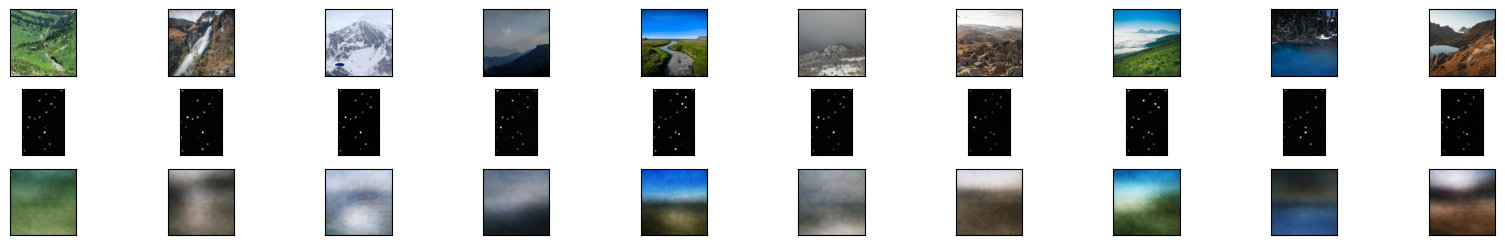

In [ ]:
# Visualize the results
n = 10  # Number of images to display
plt.figure(figsize=(20, 5))

for i in range(n):
    # Original images
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(X_test[i].reshape(100, 100, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



    # # Noisy images
    # ax = plt.subplot(5, n, i + 1 + n)
    # plt.imshow(noisy_test[i].reshape(32,32,3))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)



    # Encoded images
    # ax = plt.subplot(5, n, i + 1 + 2 * n)
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(noisy_code[i].reshape(40,25))  # Adjust the reshape dimensions based on the actual shape of encoded images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)




    # Decoded images from noisy images
    ax = plt.subplot(5, n, i + 1 + 2 * n)
    # ax = plt.subplot(5, n, i + 1 + 3 * n)
    plt.imshow(denoised_code[i].reshape(100, 100, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.show()


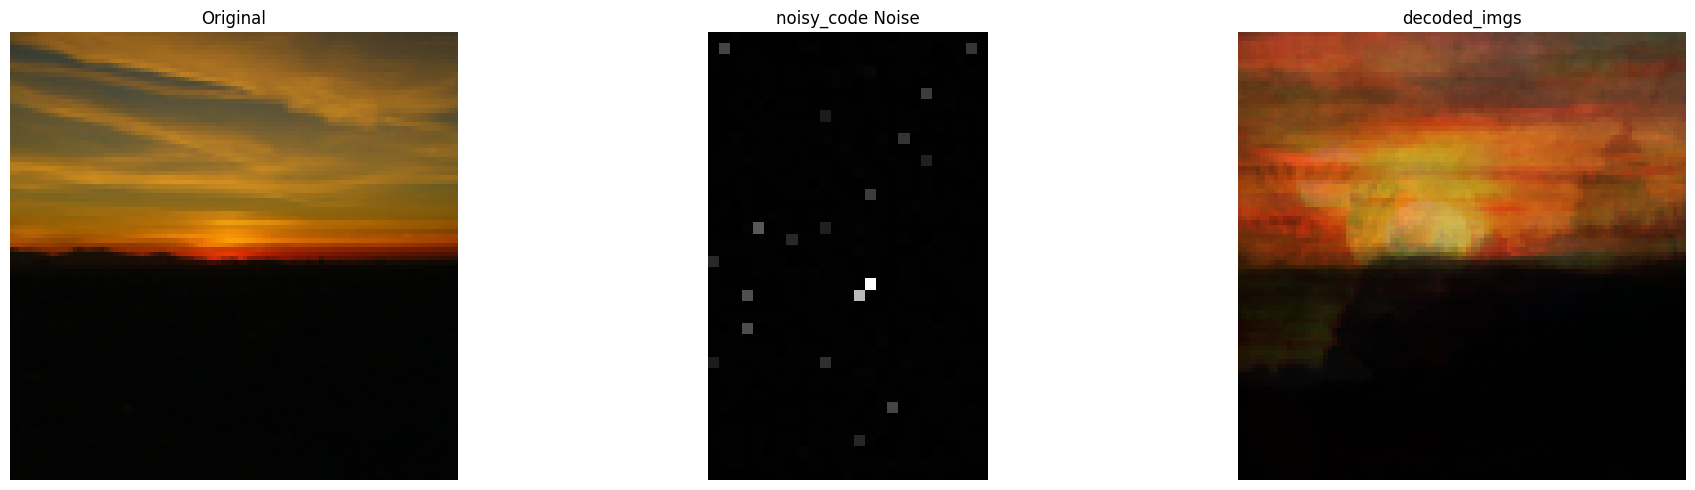

In [ ]:
fig=plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.imshow(X_test[51].reshape(100, 100, 3))
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(noisy_code[51].reshape(40, 25))
plt.axis("off")
plt.title("noisy_code Noise")

# fig.add_subplot(1,4,3)
# plt.imshow(encoded_imgs[51].reshape(20, 50))
# plt.axis("off")
# plt.title("encoded_imgs")

fig.add_subplot(1,3,3)
plt.imshow(denoised_code[51].reshape(100, 100, 3))
plt.axis("off")
plt.title("decoded_imgs")


# Add tight layout after all subplots
fig.tight_layout()

# Show the plot
plt.show()

  #   *Apply PCA*   

In [ ]:
from sklearn.decomposition import PCA
# Perform PCA on the noisy images
pca = PCA(n_components=encoding_dim)
pca.fit(noisy_train_flatten)
reduced_noisy_images = pca.transform(noisy_train_flatten)
reconstructed_noisy_images = pca.inverse_transform(reduced_noisy_images)

In [ ]:
reduced_noisy_images.shape

(16000, 1000)

In [ ]:
# Calculate Ratio For PCA
original_image_size = noisy_train_flatten.shape
compressed_image_size = reduced_noisy_images.shape
compression_ratio_images = np.prod(compressed_image_size) / np.prod(original_image_size)
print("Compression Ratio (Images):", compression_ratio_images)

Compression Ratio (Images): 0.03333333333333333


In [ ]:
# Calculate Ratio For PCA
original_image_size = noisy_train_flatten.shape
reconstructed_noisy_img = reconstructed_noisy_images.shape
compression_ratio_images = np.prod(reconstructed_noisy_img) / np.prod(original_image_size)
print("Compression Ratio (Images):", compression_ratio_images)

Compression Ratio (Images): 1.0


In [ ]:
# Calculate Ratio For Autoencoder
original_image_size = X_test_flatten.shape
reconstructed_noisy_decoded_imgs = decoded_imgs.shape
compression_ratio_images = np.prod(reconstructed_noisy_decoded_imgs) / np.prod(original_image_size)
print("Compression Ratio (Images):", compression_ratio_images)

Compression Ratio (Images): 1.0


In [ ]:
# Calculate Ratio For Autoencoder
original_image_size = X_test_flatten.shape
noisy_encoded_imgs = encoded_imgs.shape
compression_ratio_images = np.prod(noisy_encoded_imgs) / np.prod(original_image_size)
print("Compression Ratio (Images):", compression_ratio_images)

Compression Ratio (Images): 0.03333333333333333


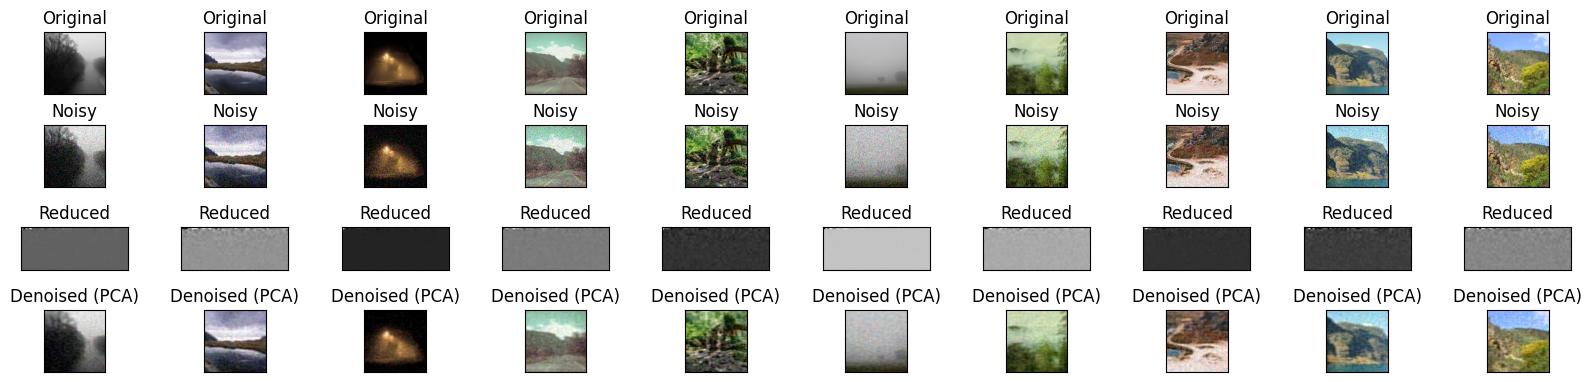

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'X_train', 'noisy_train', 'reduced_noisy_images', and 'reconstructed_noisy_images' are your original, noisy, PCA-reconstructed, and reduced images

# Visualize the original, noisy, reduced, and reconstructed images
n = 10  # Number of images to visualize
plt.figure(figsize=(20, 5))

for i in range(n):
    # Original images
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_train[i].reshape(100, 100, 3))
    plt.title('Original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(noisy_train[i].reshape(100, 100, 3))
    plt.title('Noisy')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reduced images
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(reduced_noisy_images[i].reshape(20, 50))  # Adjust the shape based on your reduced images
    plt.title('Reduced')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images from PCA
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(reconstructed_noisy_images[i].reshape(100, 100, 3))
    plt.title('Denoised (PCA)')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.2)

plt.show()


  #   *Apply CNN*   

Using CNN as an input layer for the decoder instead of a fully connected layer

In [ ]:
# noisy_train = noisy_train.reshape(len(noisy_train), 100, 100, 3)
# noisy_test = noisy_test.reshape(len(noisy_test), 100, 100, 3)
# X_train=X_train.reshape(len(X_train),100, 100, 3)
# X_test=X_test.reshape(len(X_test),100, 100, 3)

In [ ]:
# from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
# from keras.models import Model

# input_img = Input(shape=(100, 100, 3))

# # Encoder
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # Decoder with CNN layers
# x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(encoded)
# x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# # Create models
# autoencoder = Model(input_img, decoded)
# encoder = Model(input_img, encoded)

# # Compile the autoencoder
# autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.models import Model

input_img = Input(shape=(100, 100, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder with CNN layers
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(encoded)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Set the number of filters to 3

# Create models
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
autoencoder.fit(noisy_train, X_train, epochs=10,
#                 batch_size=128,
                shuffle=True,
                validation_data=(noisy_test, X_test))

Epoch 1/10
500/500 [==============================] - 20s 25ms/step - loss: 0.0097 - val_loss: 0.0041
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 5/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/10
500/500 [==============================] - 11s 22ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 10/10
500/500 [==============================] - 11s 22ms/step - loss: 0.002

In [ ]:
# # Get encoded representations
# encoded_imgs = encoder.predict(noisy_test)

# # Get denoised images
# denoised_imgs = autoencoder.predict(encoded_imgs)

In [ ]:
denoised_imgs = autoencoder.predict(noisy_test)

63/63 [==============================] - 1s 9ms/step


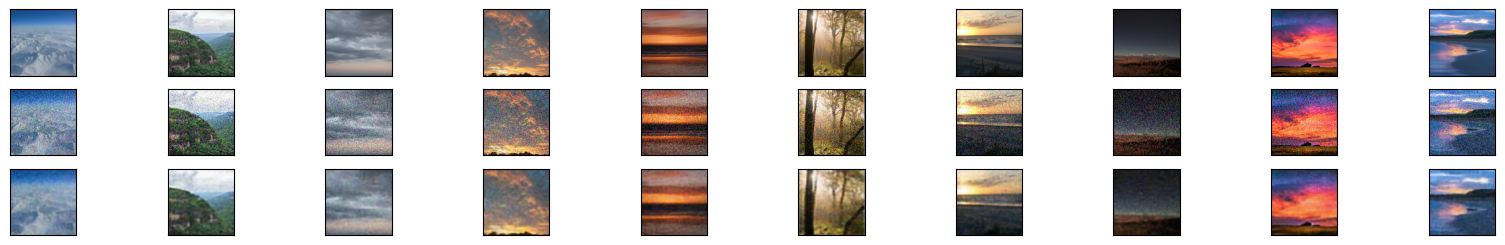

In [ ]:
# Visualize the results
n = 10  # Number of images to display
plt.figure(figsize=(20, 5))

for i in range(n, 20):
    # Original images
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(X_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noisy images
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(noisy_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#     # Encoded images (displaying the first channel)
#     ax = plt.subplot(5, n, i + 1 + 2 * n)
#     plt.imshow(encoded_imgs[i][:, :, 0], cmap='gray')  # Displaying the first channel
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

    # Decoded images from noisy images
    ax = plt.subplot(5, n, i + 1 + 2 * n)
    plt.imshow(denoised_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


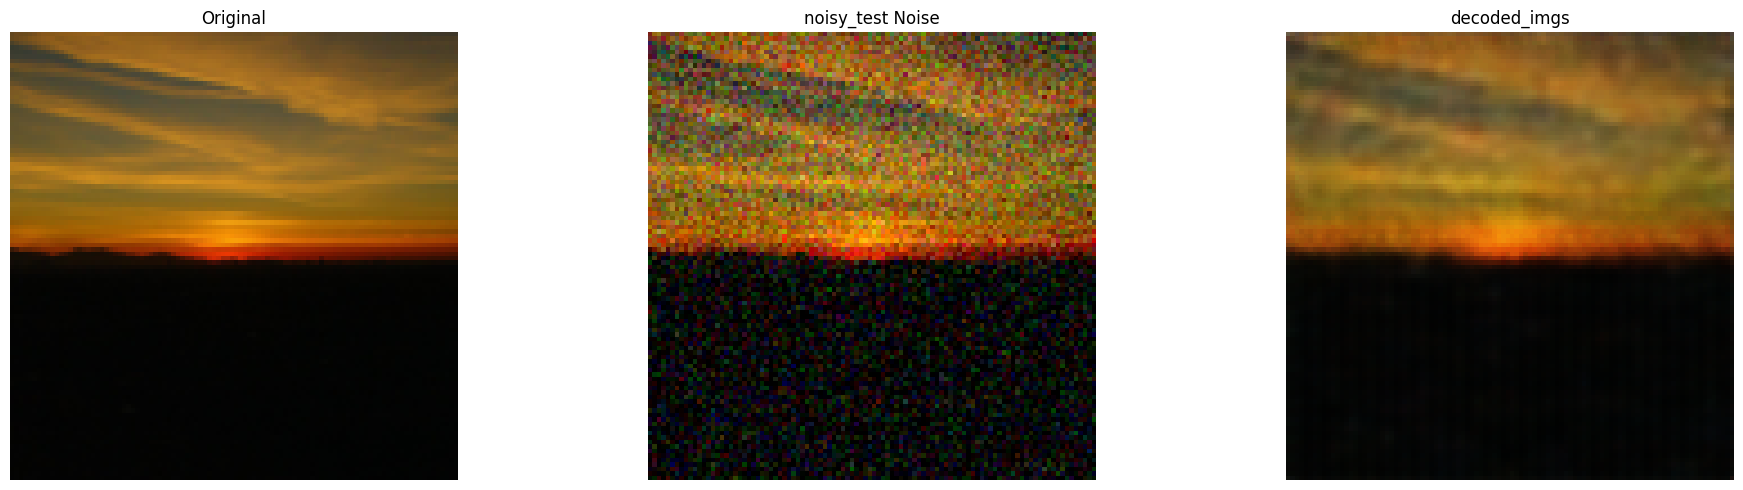

In [ ]:
fig=plt.figure(figsize=(20,5))

fig.add_subplot(1,3,1)
plt.imshow(X_test[51])
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(noisy_test[51])
plt.axis("off")
plt.title("noisy_test Noise")


fig.add_subplot(1,3,3)
plt.imshow(denoised_imgs[51])
plt.axis("off")
plt.title("decoded_imgs")


# Add tight layout after all subplots
fig.tight_layout()

# Show the plot
plt.show()